# Capstone Project for Investment and Trading

In this project, we will try to refute Efficient Market Hypothesis by outperforming the market index. Following active management, We will construct a portfolio of stocks with help of machine learning to simply do better than the market index, S&P500
Followings are step by step strategies to achieve our desired goal:

1) Predict S&P500 future return from current input features: daily, weekly S&P500 return, other market return index(DAX, NIK), trade volume, price of commodities, and so on.

2) For every stocks in S&P500, run regression to fit a line where x is S&P500 and y is an individual stock. Gradient of this fitted line is called beta in CAPM theory and it signals how stock move relative to the market.

3) We now have to select proper stocks depending on our S&P500 future forecast. Our solution guides us to select high beta stocks when market is expected to rise and select low beta stocks vice versa. Detail explanation will be given later for this logic.

4) After selecting bucket of stocks, we seek for optimal allocation weight for each stock that maximize portfolio's return or risk adjusted return.

5) In simulation, we will iterate step 1) - 4) for daily basis.

<font color='gray' size=4> (1) Predict S&P500: Sourcing market Data from Quandl </font> 

This script is for downloading financial data required for predicting S&P500 daily return. Source is from Quandl API and <font color='red'>do not need to run this</font> since everything is already downloaded as parsed as CSV files in local directories. There are many options for representing stock price data. In this project we will only use adjusted close price, because this compensates for any price anomaly resulting from dividends or stock split.

In [17]:
import quandl
import utility as util
import process as proc

quandl.ApiConfig.api_key = "dmDantC6pfu5ZsSZ9Zny"

date_range = ["2010-01-01", "2016-12-31"]
#spy: S&P500 index
spy = quandl.get("YAHOO/INDEX_GSPC", start_date=date_range[0], end_date=date_range[1])
#nasdaq: NASDAQ composite index
nas = quandl.get("YAHOO/INDEX_IXIC", start_date=date_range[0], end_date=date_range[1])
#dax: German stock market index
dax = quandl.get("YAHOO/INDEX_GDAXI", start_date=date_range[0], end_date=date_range[1])
#nikkei 225: Japan stock market index
nik = quandl.get("YAHOO/INDEX_N225", start_date=date_range[0], end_date=date_range[1])
#kpi: KOSPI index from Korea
#kpi = quandl.get("YAHOO/INDEX_KS11", start_date=date_range[0], end_date=date_range[1])
#glf: Chicago Merchandile Exchange NYMEX Gold Futures
glf = quandl.get("CHRIS/CME_GC1", start_date=date_range[0], end_date=date_range[1])
#oif: Crude Oil Futures based on spot-month continuous contract 
olf = quandl.get("CHRIS/CME_CL1", start_date=date_range[0], end_date=date_range[1])

spy = spy.rename(columns = {'Volume':'SPY:Volume', 'Adjusted Close':'SPY:Price'})
nas = nas.rename(columns = {'Volume':'NAS:Volume', 'Adjusted Close':'NAS:Price'})
dax = dax.rename(columns = {'Volume':'DAX:Volume', 'Adjusted Close':'DAX:Price'})
nik = nik.rename(columns = {'Volume':'NIK:Volume', 'Adjusted Close':'NIK:Price'})
#kpi = kpi.rename(columns = {'Volume':'KPI:Volume', 'Adjusted Close':'KPI:Price'})
glf = glf.rename(columns = {'Volume':'GLF:Volume', 'Settle':'GLF:Price'})
olf = olf.rename(columns = {'Volume':'OLF:Volume', 'Settle':'OLF:Price'})

#Set date index from spy as a reference
date_index = spy.index.get_values()

#Get processed dataframe
df = proc.get_mkt_data(date_index, spy, nas, dax, nik, glf, olf)

#Save data to csv file
util.save_data('mkt_price_volume.csv',df)

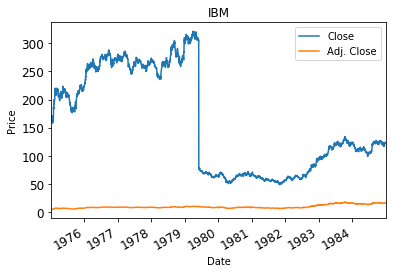

In [18]:
import quandl
import utility as util

IBM = quandl.get("WIKI/IBM", start_date="1975-01-01", end_date="1985-01-01")
util.plot_data(IBM[['Close', 'Adj. Close']], 'IBM', xlable='Date', ylable='Price')

Before actually touching on some data, lets explore, visualize, and find out some statistics.

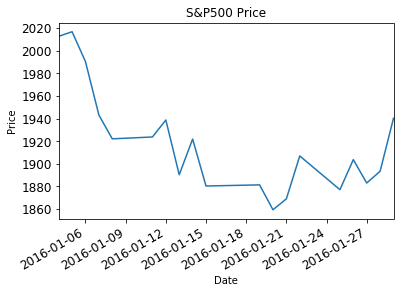

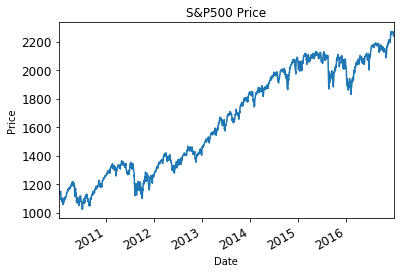

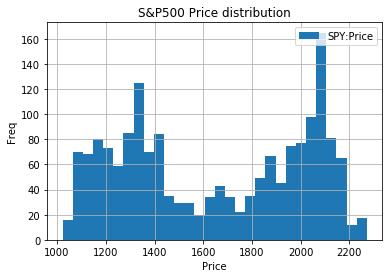

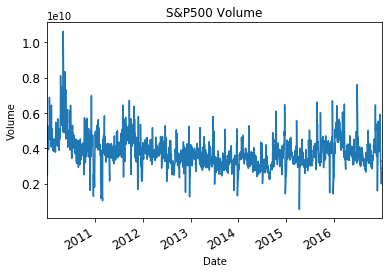

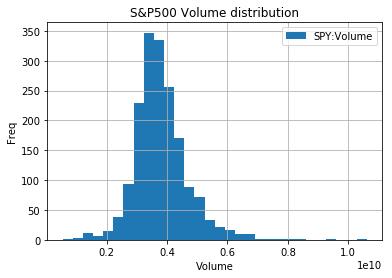

Statistics for S&P500 Price
     statistic           value
------------------------------
          size      1762.00000
           min      1022.58002
           max      2271.71997
          mean      1645.70950
           std       371.29317
          skew        -0.01582
      kurtosis        -1.53155

Statistics for S&P500 Volume
     statistic           value
------------------------------
          size      1762.00000
           min 536200000.00000
           max 10617809600.00000
          mean 3796473024.74461
           std 879457321.79412
          skew         1.06084
      kurtosis         4.83376


In [19]:
import utility as util
import process as proc

util.plot_data(spy['SPY:Price'].ix["2016-01-04":"2016-01-30"], 'S&P500 Price', xlable ='Date', ylable='Price')
util.plot_data(spy['SPY:Price'], 'S&P500 Price', xlable ='Date', ylable='Price')
util.plot_histogram(spy[['SPY:Price']], 'S&P500 Price distribution', xlable ='Price', ylable='Freq')
util.plot_data(spy['SPY:Volume'], 'S&P500 Volume', xlable ='Date', ylable='Volume')
util.plot_histogram(spy[['SPY:Volume']], 'S&P500 Volume distribution', xlable ='Volume', ylable='Freq')
print "Statistics for S&P500 Price"
proc.print_statistics(spy[['SPY:Price']])
print ""
print "Statistics for S&P500 Volume"
proc.print_statistics(spy[['SPY:Volume']])

<font color='gray' size=4> (2) Predict S&P500: Preprocessing input features </font> 

First step with dealing financial data is to fill missing values for every columns. Instead of using interpolation, we will just fill with latest value. This is to avoid information leaking into future to prevent optimistic result. Finally, we are ready to process input data to our learning models. However, if you see the distribution of stock price, it seems to follow somewhat binomial distribution. Hence, instead of just using price data we will turn it to a daily return. We can see that daily return, not exactly though because of fat tail, shows normal distribution. Refer to some statistics below for our daily return distribution.

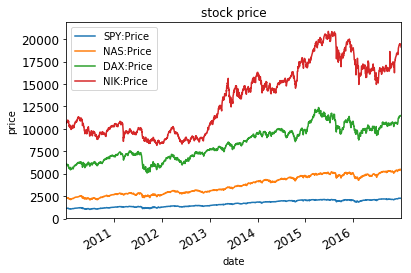

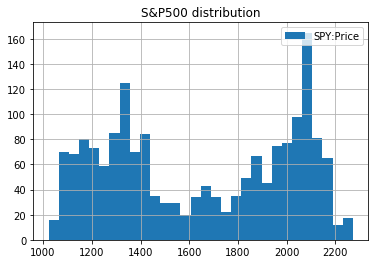

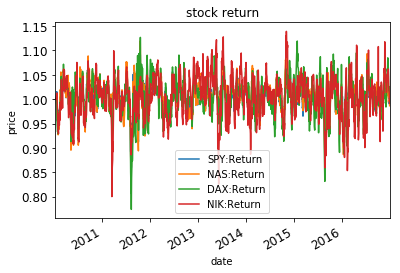

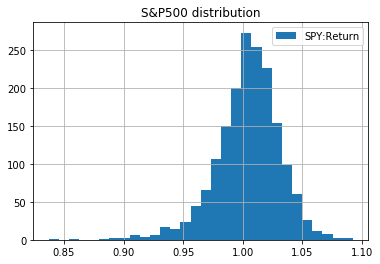

Statistics for SPY:Return
     statistic           value
------------------------------
          size      1762.00000
           min         0.83702
           max         1.09246
          mean         1.00425
           std         0.02691
          skew        -0.78328
      kurtosis         2.49443


In [5]:
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Read data from CSV files
mkt_df = proc.read_mkt_data('mkt_price_volume.csv')
# Display a description of the dataset
#display(mkt_df.describe())

# Fill missing value
data_before = proc.fill_missing_values(mkt_df)

# Divide data into categories(stock index, commodity, interest rates)
stock_price = data_before[['SPY:Price', 'NAS:Price', 'DAX:Price', 'NIK:Price']]
commodity_price = data_before[['GLF:Price', 'OLF:Price']]

# Before Preprocessing data
util.plot_data(stock_price, 'stock price')
util.plot_histogram(stock_price[['SPY:Price']], 'S&P500 distribution')

# Preprocess: Price to Daily Returns, this also changes volume to daily increase
data_after = proc.price_to_return(data_before, 'Price', 'Return', day_10)

# Divide data into categories(stock index, commodity, interest rates)
stock_return = data_after[['SPY:Return', 'NAS:Return', 'DAX:Return', 'NIK:Return']]
commodity_return = data_after[['GLF:Return', 'OLF:Return']]

# After Preprocessing data
util.plot_data(stock_return, 'stock return')
util.plot_histogram(stock_return[['SPY:Return']], 'S&P500 distribution')

print "Statistics for SPY:Return"
proc.print_statistics(stock_return['SPY:Return'])

We can apply same converting logic to volume data. Volume means trade volume, quantity of an order made in each day. As you can see from below figure however, raw volume data is acts like somewhat normal distribution. In addition to this raw data, we will add rolling mean for n day. This is because, at first I thought that if we can see some trend of volume movement it might help in describing market movement.

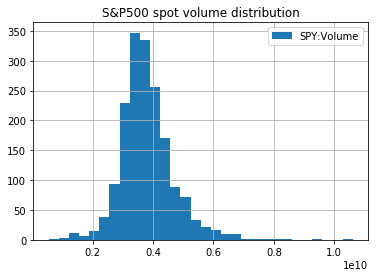

Statistics for SPY:Volume
     statistic           value
------------------------------
          size      1762.00000
           min 536200000.00000
           max 10617809600.00000
          mean 3796473024.74461
           std 879457321.79412
          skew         1.06084
      kurtosis         4.83376


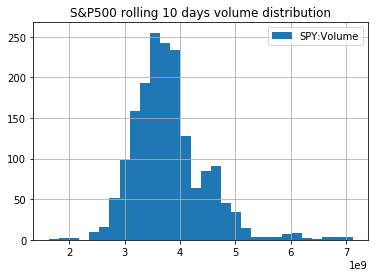

Statistics for SPY:Volume(10D)
     statistic           value
------------------------------
          size      1762.00000
           min 1626553000.00000
           max 7121765000.00000
          mean 3801428562.76958
           std 655254810.13675
          skew         1.15130
      kurtosis         3.04685


In [16]:
# Divide data into categories(stock index, commodity, interest rates)
volume = data_before[['SPY:Volume']]

# Preprocess
rolling_volume = proc.get_rolling_mean(spy_volume, day_10)
rolling_volume = proc.fill_missing_values(spy_rolling_volume)

# Before Preprocessing data
util.plot_histogram(volume, 'S&P500 spot volume distribution')
print "Statistics for SPY:Volume"
proc.print_statistics(volume['SPY:Volume'])

# After Preprocessing data
util.plot_histogram(rolling_volume, 'S&P500 rolling 10 days volume distribution')
print "Statistics for SPY:Volume(10D)"
proc.print_statistics(rolling_volume['SPY:Volume'])

<font color='gray' size=4> (3) Predict S&P500: Selecting features </font> 

Our goal is to predict S&P500 return, whether it's price is expected to go up or down. Our portfolio strategy heavily depends on this prediction. In order to predict S&P500 movement, we have selected various features from above. In this section, we will find relevant features for predicting S&P500 return.

                 SPY:Target  GLF:Return(10D)  SPY:Return(10D)  NAS:Return(10D)
SPY:Target         1.000000        -0.033123         0.429326         0.393964
GLF:Return(10D)   -0.033123         1.000000        -0.003888        -0.009722
SPY:Return(10D)    0.429326        -0.003888         1.000000         0.951875
NAS:Return(10D)    0.393964        -0.009722         0.951875         1.000000


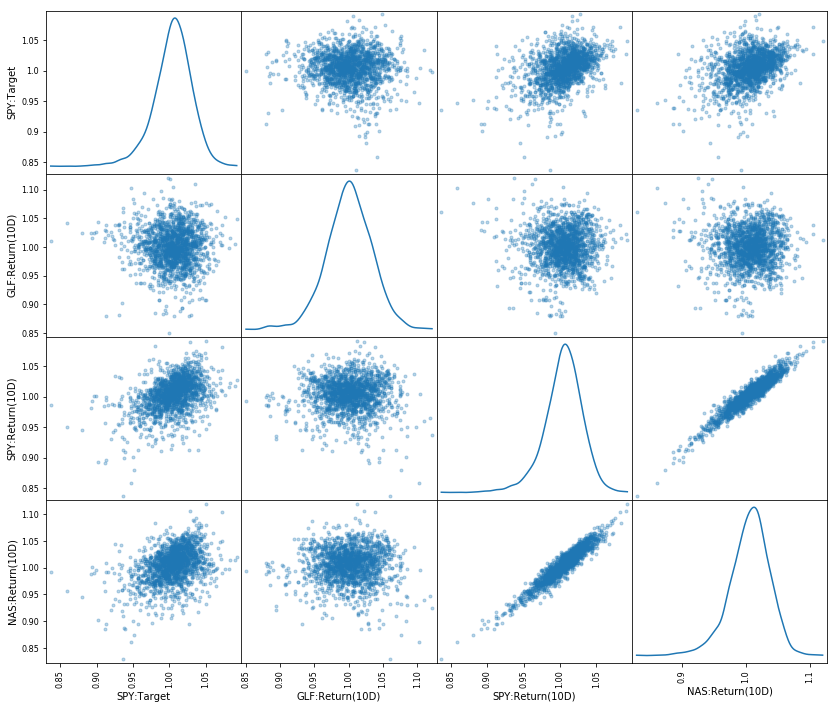

In [13]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#ScatterPlot
df = day_10_return
df = df.join(target)
df = df[['SPY:Target', 'GLF:Return(10D)', 'SPY:Return(10D)', 'NAS:Return(10D)']]
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');
print df.corr(method='pearson')

SPY is ticker for S&P500 index, and SPY:Target means future 10-day cumulative return for S&P500 starting from 5days ago. From above scatterplot, we can see that GLF(Gold Future) has low correlation with our SPY:Target value. It means that we can hardly explain our future S&P500 movement with gold future. I have tried various duration for gold future such as 1,5,10,20,30 day cumulative return, but none had meaningful result. Also, we will drop NAS(nasdaq) since this feature move almost the same as SPY(S&P500). After removing let's add some S&P500 1day, 5day, 20day ago cumulative return to our feature sets. In general, technical analyst use this n-day trailing data for extracting a signal for market trend.

                 SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
SPY:Return(10D)         1.000000         0.764184         0.624404   
DAX:Return(10D)         0.764184         1.000000         0.616134   
NIK:Return(10D)         0.624404         0.616134         1.000000   
OLF:Return(10D)         0.432435         0.322211         0.255030   
SPY:Target              0.429326         0.320363         0.226382   
SPY:Return(1D)          0.279484         0.167645         0.024329   
SPY:Return(5D)          0.644749         0.490386         0.353469   
SPY:Return(20D)         0.663314         0.538692         0.479655   

                 OLF:Return(10D)  SPY:Target  SPY:Return(1D)  SPY:Return(5D)  \
SPY:Return(10D)         0.432435    0.429326        0.279484        0.644749   
DAX:Return(10D)         0.322211    0.320363        0.167645        0.490386   
NIK:Return(10D)         0.255030    0.226382        0.024329        0.353469   
OLF:Return(10D)         1.000000    0.222915     

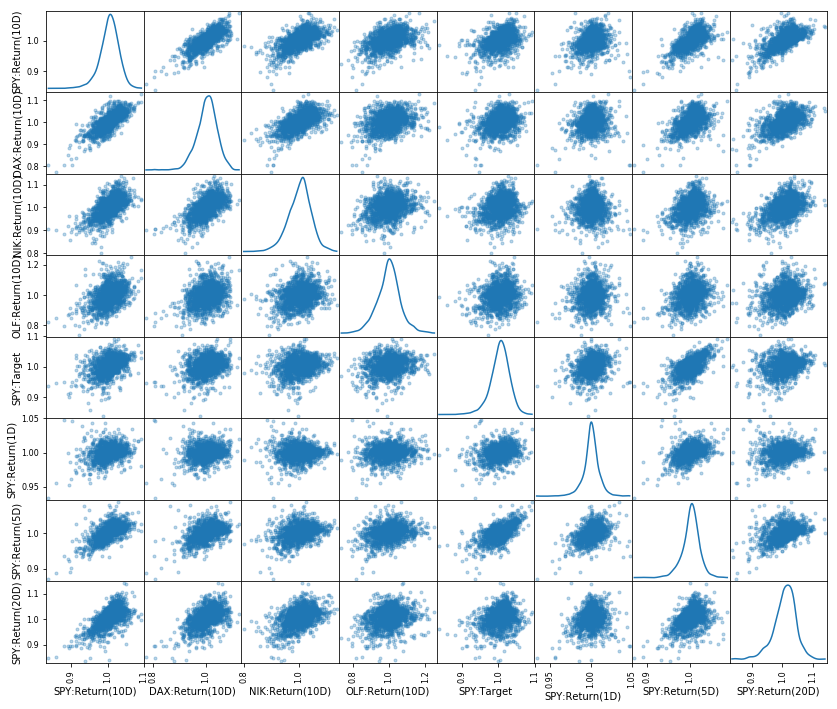

In [26]:
df.drop('GLF:Return(10D)', axis = 1, inplace = True)
df.drop('NAS:Return(10D)', axis = 1, inplace = True)
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

print df.corr(method='pearson')
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');

Now, lets dive into volume data. For volume we will treat only volume data for S&P500. We will preprocess our raw volume data into rolling mean datas.

                 SPY:Volume(1D)  SPY:Volume(5D)  SPY:Volume(10D)  \
SPY:Volume(1D)         1.000000        0.780958         0.693605   
SPY:Volume(5D)         0.780958        1.000000         0.916926   
SPY:Volume(10D)        0.693605        0.916926         1.000000   
SPY:Volume(20D)        0.621578        0.808972         0.914313   
SPY:Target            -0.121729       -0.084534        -0.040558   

                 SPY:Volume(20D)  SPY:Target  
SPY:Volume(1D)          0.621578   -0.121729  
SPY:Volume(5D)          0.808972   -0.084534  
SPY:Volume(10D)         0.914313   -0.040558  
SPY:Volume(20D)         1.000000   -0.045456  
SPY:Target             -0.045456    1.000000  


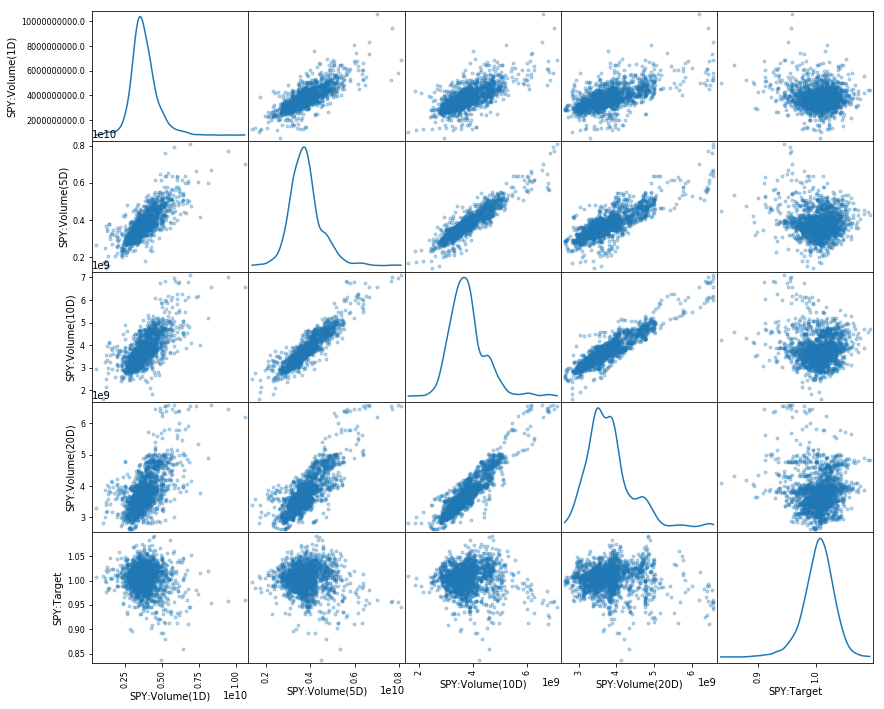

In [34]:
volume_data = proc.extract_columns(raw_data, 'Volume')
spy_volume = volume_data['SPY:Volume']
day_1_volume = proc.get_rolling_mean(spy_volume, day_1)
day_1_volume.name = spy_volume.name.replace('Volume', 'Volume(1D)')
day_5_volume = proc.get_rolling_mean(spy_volume, day_5)
day_5_volume.name = spy_volume.name.replace('Volume', 'Volume(5D)')
day_10_volume = proc.get_rolling_mean(spy_volume, day_10)
day_10_volume.name = spy_volume.name.replace('Volume', 'Volume(10D)')
day_20_volume = proc.get_rolling_mean(spy_volume, day_20)
day_20_volume.name = spy_volume.name.replace('Volume', 'Volume(20D)')

df = pd.DataFrame(index=target.index.get_values())
df = df.join(day_1_volume)
df = df.join(day_5_volume)
df = df.join(day_10_volume)
df = df.join(day_20_volume)
df = df.join(target)
df = proc.fill_missing_values(df)

print df.corr(method='pearson')
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,12), diagonal = 'kde');

Unfortunately, we could not find any relavance between rolling mean of volume of S&P500 and future cumulative return of S&P500. To summarize, with regards to feature inputs, we will use 10 day cumulative return from SPY, DAX, NIK, OLF and daily return, 5-day cumulative return, and 20-day cumulative return for S&P500. All this inputs are for predicting future S&P500 index. 

<font color='gray' size=4> (4) Predict S&P500: Model Learning & Validation </font> 

Now we are ready to learn our model. First, we will preprocess raw data, drop and select some features. Details can be found (3) Selecting Features.

In [10]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
price_data.drop('GLF:Price', axis = 1, inplace = True)
price_data.drop('NAS:Price', axis = 1, inplace = True)

day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#features
df = day_10_return
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

print df.head()

            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2010-01-04              1.0              1.0              1.0   
2010-01-05              1.0              1.0              1.0   
2010-01-06              1.0              1.0              1.0   
2010-01-07              1.0              1.0              1.0   
2010-01-08              1.0              1.0              1.0   

            OLF:Return(10D)  SPY:Return(1D)  SPY:Return(5D)  SPY:Return(20D)  
2010-01-04              1.0        1.000000             1.0              1.0  
2010-01-05              1.0        1.003116             1.0              1.0  
2010-01-06              1.0        1.000546             1.0              1.0  
2010-01-07              1.0        1.004001             1.0              1.0  
2010-01-08              1.0        1.002882             1.0              1.0  


We will divide our data into training sets and testing set. We will use 2010-2015 data for training and 2015-2016 data for simulating our portfolio strategy. But before that, we have to take care of some NaN values and fake values that come from rolling mean and cumultavie mean. Simply, we will exclude meaningless data. Front 20, and last 20 data will be removed. 

In [11]:
train_range = ["2010-01-01", "2015-12-31"]
test_range = ["2016-01-01", "2016-12-31"]

df_after = df[day_20:-day_20]
target_after = target[day_20:-day_20]

X_train = df_after.ix[train_range[0]:train_range[1]]
y_train = target_after.ix[train_range[0]:train_range[1]]
X_test = df_after.ix[test_range[0]:test_range[1]]
y_test= target_after.ix[test_range[0]:test_range[1]]

print X_train.head()
print X_test.tail()

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2010-02-02         0.959217         0.955355         0.963417   
2010-02-03         0.964184         0.969335         0.968970   
2010-02-04         0.952198         0.962810         0.952851   
2010-02-05         0.976579         0.954176         0.949629   
2010-02-08         0.963493         0.973981         0.946648   

            OLF:Return(10D)  SPY:Return(1D)  SPY:Return(5D)  SPY:Return(20D)  
2010-02-02         0.977348        1.012973        1.010209         0.973813  
2010-02-03         0.991755        0.994526        0.999800         0.965474  
2010-02-04         0.961356        0.968859        0.980249         0.934898  
2010-02-05         0.955058        1.002897        0.992848         0.933870  
2010-02-08         0.955222        0.991137        0.970207         0.922933  
            SPY:Return(10D)  DAX:Return(10D)  NIK:Return(10D)  \
2016-11-25         1.021163         1.006505         1.059777   
2016-

Typical usage of cross validation does not fit financial data application well. The reason is that it can permit peeking into the future. For instance, if our training data is after testing data that means we are seeing the future ahead of our test. Any sort of peeking like this can read to unrealistically optimistic results. This is why we divided train(2010-2015), test(2015-2016) sets in chronogical order rather than using train_test_split function from sklearn.cross_validation. One way to avoid this problem is with role forward cross validation. That mean our training data is always before testing data. And we can still have multiple trials just by rolling our data forward till we run out of data.

In [14]:
import run
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

reg_knn = KNeighborsRegressor()
reg_dt = DecisionTreeRegressor()
reg_svr = SVR()
reg_rf = RandomForestRegressor()

params_knn = {'n_neighbors': range(5,31), 'weights': ['uniform','distance']}
params_dt = {'max_depth': range(1,10)}
params_svr = {'kernel': ['rbf', 'linear'], 
              'C': [0.1, 1.0, 3.0, 10.0],
              'epsilon': [0.001, 0.01, 0.03, 0.1]}
params_rf = {'n_estimators': [20,30,40],
             'max_depth': range(1,10)}

# Fit the training data to the model using grid search
#reg = run.fit_regression(reg_dt, X_train, y_train, params_dt)
#reg = run.fit_regression(reg_knn, X_train, y_train, params_knn)
#reg = run.fit_regression(reg_svr, X_train, y_train, params_svr)
reg = run.fit_regression(reg_rf, X_train, y_train, params_rf)

# Produce the value for 'max_depth'
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])
print "Parameter 'n_estimators' is {} for the optimal model.".format(reg.get_params()['n_estimators'])

#print "Parameter 'kernel' is {} for the optimal model.".format(reg.get_params()['kernel'])
#print "Parameter 'C' is {} for the optimal model.".format(reg.get_params()['C'])
#print "Parameter 'epsilon' is {} for the optimal model.".format(reg.get_params()['epsilon'])

#print "Parameter 'n_neighbors' is {} for the optimal model.".format(reg.get_params()['n_neighbors'])
#print "Parameter 'weights' is {} for the optimal model.".format(reg.get_params()['weights'])

print run.get_r2_score(reg, X_test, y_test)

Parameter 'max_depth' is 3 for the optimal model.
Parameter 'n_estimators' is 20 for the optimal model.
0.512570661714


<font color='gray' size=4> (5) Portfolio Construction Strategy: Selecting Stocks </font> 

To construct market beating portfolio, we should select appropriate stocks depending on market. For instance, we would select high beta stocks if we are in bull market and low beta stock if in bear market

We will use stocks from S&P500 list for constructing portfolio. Below is code for downloading financial data for stocks that are constitunt of S&P500. Do not run this code because it will take too much time.

In [3]:
import quandl
import process as proc
import utility as util

quandl.ApiConfig.api_key = "dmDantC6pfu5ZsSZ9Zny"

mkt_df = proc.read_mkt_data('mkt_price_volume.csv')
date_range = ["2010-01-01", "2016-12-31"]
date_index = mkt_df.index.get_values()
 
stock_df = proc.get_total_stocks('S&P500_list.csv', date_index, date_range)
util.save_data('S&P500_stocks_price.csv', stock_df)

0. 3M Company Download & Parse complete
1. Abbott Laboratories Download & Parse complete
2. AbbVie Download & Parse complete
3. Accenture plc Download & Parse complete
4. ACE Limited Download & Parse complete
5. Activision Blizzard Download & Parse complete
6. Adobe Systems Inc Download & Parse complete
7. ADT Corp Download & Parse complete
8. Advance Auto Parts Download & Parse complete
9. AES Corp Download & Parse complete
10. Aetna Inc Download & Parse complete
11. AFLAC Inc Download & Parse complete
12. Affiliated Managers Group Inc Download & Parse complete
13. Agilent Technologies Inc Download & Parse complete
14. AGL Resources Inc. Download & Parse complete
15. Air Products & Chemicals Inc Download & Parse complete
16. Airgas Inc Download & Parse complete
17. Akamai Technologies Inc Download & Parse complete
18. Alcoa Inc Download & Parse complete
19. Allergan plc Download & Parse complete
20. Alexion Pharmaceuticals Download & Parse complete
21. Allegion Download & Parse comple

To avoid survivors bias which might accidentally happen if we tend to use survived companies from 2016 S&P500 constituent, we will only use stocks that has existed from 2010.

In [2]:
import process as proc
import numpy as np

spy = proc.read_mkt_data('mkt_price_volume.csv')
spy = spy['SPY:Price']
spy.name = 'SPY'
# Preprocess data
stocks = proc.read_stock_data('S&P500_stocks_price.csv', verbose=True)
stocks = proc.fill_missing_values(stocks)
stocks = stocks.join(spy)

List of companies dropped due to insufficient data
ABBV
ACE
ADT
GAS
ARG
AA
ALLE
GOOG
ALTR
BXLT
BRCM
CVC
CAM
CCE
CPGX
CMCSK
CSC
CNX
DLPH
EMC
ESV
FB
FOSL
GM
GNW
HCA
HCBK
GMCR
KMI
KHC
LM
LYB
MNK
MPC
MHFI
WRK
KORS
NAVI
NWSA
NWS
NLSN
OI
PYPL
POM
PSX
PCL
PCP
QRVO
SNDK
SIAL
HOT
TE
TGNA
THC
TWC
TRIP
TYC
WBA
ANTM
XYL
ZBH
ZTS


To derive beta value for every stock, we have to run linear regression where x domain is market and y domain is specific stock we want to calculate. We do not want to use stocks that have poor correlation with the market because this means that price movement is somewhat random when compared to the market. We want stocks that show strong relationship to market.

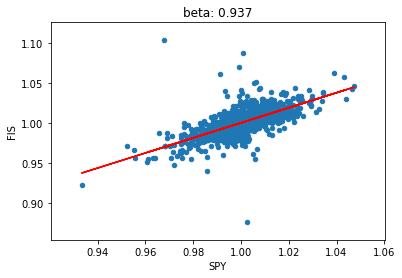

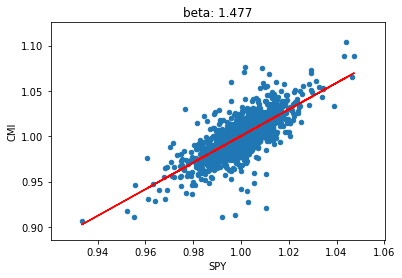

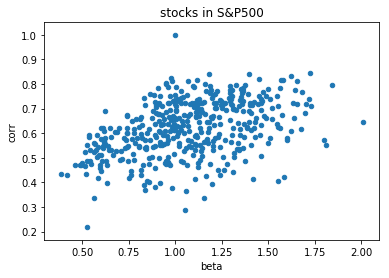

In [15]:
import run
import matplotlib.pyplot as plt
import utility as util
# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

capm = run.get_stocks_CAPM(stocks)
#capm = capm.sort_values(['beta'], ascending=[1]) 
#capm = capm[(capm['corr'] > capm['corr'].quantile(0.5))]
#print capm
util.plot_stock_CAPM(stocks, 'FIS', "beta: 0.937")
util.plot_stock_CAPM(stocks, 'CMI', 'beta: 1.477')
capm.plot(kind='scatter', x='beta', y='corr', title='stocks in S&P500')
plt.show()

#print capm.head()

<font color='gray' size=4> (6) Portfolio Construction Strategy: Weight Allocation </font> 

Final step is to decide optimal allocation for each stocks that would be in our portfolio. Point here is that even though we have same stocks in our portfolio, how we allocate weights to them can greatly affect in overall performance of our portfolio. In this project, we optimize this weights using historical data. We use optimizer which maximize our given function. We will compare between three metric function. (1) Function that maximize Sharpe ratio (2) Function that maximize return (3) Function that minimize risk/variance 

<font color='gray' size=4> (7) Simulation </font> 

Now we are ready to run simulation and see how our constructed portfolio can actually outperform market index.

1) Forecasting S&P500 return from current and past data: We will use data from 2010 to 2015 for training. Models that can be used here is (1)KNN, (2)DecisionTree, (3)SVR, (4)Random Forest. Optimal parameter for each model is  KNN(n_neighbors=27, weights='distance'), DecisionTree(max_depth=3), SVR(kernel='rbf', C=10.0, epsilon='0.001'), Random Forest(max_depth=3, n_estimator='40').

2) Selecting appropriate stocks depending on market forecast: Parameter option for this section is (1) Number of company is portfolio(default = 20) (2) Correlation Threshold(default = 0.7)

3) Finding optimal weights for stocks that maximize portfolio's return: Optimizing function to be used here are (1) Maximizing Sharpe Ratio (2) Maximizing Return (3) Minimizing Risk

Our simulation will run from 2016-01-04 to 2016-12-31. We make 5 day ahead S&P500 forecast everyday. Whenever there is signal of changing from bull to bear or bear to bull, we re-select our stocks depending on market forecast. By default, we will include top 20 high/low beta companies that have correlation value greater than it's 60% quantile. 

In [36]:
import pandas as pd
import utility as util
import process as proc
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import run
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

day_1 = 1
day_5 = 5
day_10 = 10
day_20 = 20

# Read data from CSV files
raw_data = proc.read_mkt_data('mkt_price_volume.csv')

# Fill missing value
raw_data = proc.fill_missing_values(raw_data)
price_data = proc.extract_columns(raw_data, 'Price')
price_data.drop('GLF:Price', axis = 1, inplace = True)
price_data.drop('NAS:Price', axis = 1, inplace = True)

day_1_return = proc.price_to_return(price_data, 'Price', 'Return(1D)', day_1)
day_5_return = proc.price_to_return(price_data, 'Price', 'Return(5D)', day_5)
day_10_return = proc.price_to_return(price_data, 'Price', 'Return(10D)', day_10)
day_20_return = proc.price_to_return(price_data, 'Price', 'Return(20D)', day_20)

#target
target = day_10_return['SPY:Return(10D)'].shift(-5)
target.name = target.name.replace('Return(10D)', 'Target')

#features
df = day_10_return
df = df.join(day_1_return['SPY:Return(1D)'])
df = df.join(day_5_return['SPY:Return(5D)'])
df = df.join(day_20_return['SPY:Return(20D)'])

train_range = ["2010-01-01", "2015-12-31"]

X = df[day_20:-5]
y = target[day_20:-5]

X_train = X.ix[train_range[0]:train_range[1]]
y_train = y.ix[train_range[0]:train_range[1]]

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

#reg = RandomForestRegressor(n_estimators=30, max_depth=3)
#reg = DecisionTreeRegressor(max_depth=3)
#reg = KNeighborsRegressor(n_neighbors=21, weights = 'distance')
reg = SVR(kernel = 'rbf', C = 10.0, epsilon = 0.001)

reg = reg.fit(X_train, y_train)
print "Training Done"
#Stock datas
spy = proc.read_mkt_data('mkt_price_volume.csv')
spy = spy[['SPY:Price']]
spy = spy.rename(columns = {'SPY:Price':'SPY'})
# Preprocess data
stocks = proc.read_stock_data('S&P500_stocks_price.csv', verbose=False)
stocks = proc.fill_missing_values(stocks)
stocks = spy.join(stocks)
stocks = stocks[day_20:-5]

Training Done


In [41]:
simulation_range = ["2016-01-01", "2016-12-31"]
portfolio_sharpe = run.simulation(reg, X, y, stocks, simulation_range, rollback=252, n_company=30, corr = 0.7, method='sharpe')
portfolio_return = run.simulation(reg, X, y, stocks, simulation_range, rollback=252, n_company=30, corr = 0.7, method='return')
portfolio_risk = run.simulation(reg, X, y, stocks, simulation_range, rollback=252, n_company=30, corr = 0.7, method='risk')

[2016-01-25T00:00:00.000000000]Market status change: bear -> bull, current portfolio value: 1.00335095789
[2016-02-05T00:00:00.000000000]Market status change: bull -> bear, current portfolio value: 0.986580302881
[2016-02-16T00:00:00.000000000]Market status change: bear -> bull, current portfolio value: 1.00152327613
[2016-03-28T00:00:00.000000000]Market status change: bull -> bear, current portfolio value: 1.00811196208
[2016-03-29T00:00:00.000000000]Market status change: bear -> bull, current portfolio value: 1.02137146185
[2016-04-05T00:00:00.000000000]Market status change: bull -> bear, current portfolio value: 1.00824546839
[2016-04-06T00:00:00.000000000]Market status change: bear -> bull, current portfolio value: 1.01313991384
[2016-04-07T00:00:00.000000000]Market status change: bull -> bear, current portfolio value: 0.996840080042
[2016-04-12T00:00:00.000000000]Market status change: bear -> bull, current portfolio value: 1.00183170006
[2016-04-29T00:00:00.000000000]Market status

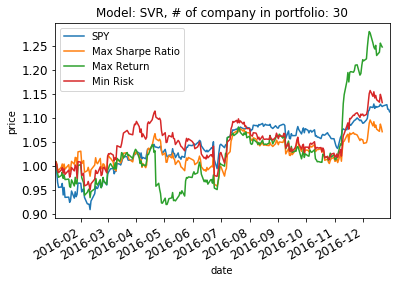

In [42]:
import utility as util
import process as proc

spy = spy.ix[simulation_range[0]:simulation_range[1]]
spy = proc.normalize_firstrow(spy)
portfolio_sharpe = portfolio_sharpe.rename(columns = {'value':'Max Sharpe Ratio'})
portfolio_return = portfolio_return.rename(columns = {'value':'Max Return'})   
portfolio_risk = portfolio_risk.rename(columns = {'value':'Min Risk'})                                                         
spy = spy.rename(columns = {'SPY:Price':'SPY'})
result = spy.join(portfolio_sharpe[['Max Sharpe Ratio']])
result = result.join(portfolio_return[['Max Return']])
result = result.join(portfolio_risk[['Min Risk']])
util.plot_data(result, title='Model: SVR, # of company in portfolio: 30')

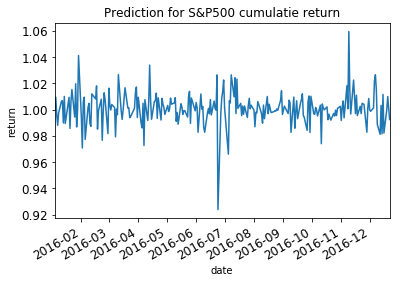

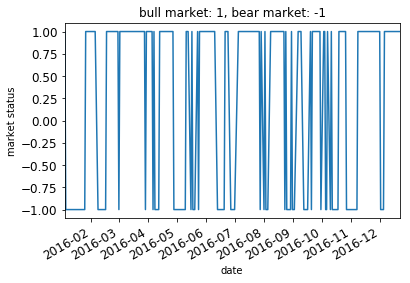

In [8]:
util.plot_data(portfolio['return'], title='Prediction for S&P500 cumulatie return', ylable='return')
util.plot_data(portfolio['market'], title='bull market: 1, bear market: -1', ylable='market status')